<a href="https://colab.research.google.com/github/Plogeur/HAI923/blob/main/Notebook_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<H1> Notebook : Création des modèles CNN </H1>

Le modèles de réseaux de neurones convolutionnels Convolutional Neural Networks, sont devenus l'épine dorsale de nombreuses applications de pointe en traitement d'images, de la détection d'objets à la segmentation sémantique en passant par la reconnaissance d'images. Au cours de ce notebook, nous aborderons des sujets tels que l'architecture de base d'un CNN, la sélection de couches de convolution, de pooling et de normalisation, ainsi que les stratégies de régularisation pour améliorer la généralisation. Nous explorerons également le transfert d'apprentissage et le fine tuning à l'aide de réseaux pré-entraînés, afin d'exploiter des modèles déjà entraînés pour résoudre des problèmes spécifiques. Enfin, à moins que la procrastination ne l'emporte, nous aborderons également les transformateurs avec l'utilisation de l'architecture ViT.

*Note à moi-même : c'est mort pour le VIT j'ai déjà la flemme de faire le reste*

# Installation

In [ ]:
!pip install keras-self-attention

  Preparing metadata (setup.py) ... done
  Created wheel for keras-self-attention: filename=keras_self_attention-0.51.0-py3-none-any.whl size=18895 sha256=b905bdfd837756be153be6b00ed5d5527d4e84a945758baa1bb4864b2d86d859
  Stored in directory: /root/.cache/pip/wheels/b8/f7/24/607b483144fb9c47b4ba2c5fba6b68e54aeee2d5bf6c05302e
Successfully built keras-self-attention


In [ ]:
import numpy as np
import os
import seaborn as sns
import random
import shutil
import keras
import pathlib
import sys
import cv2
import pandas as pd
from numpy import mean
from numpy import std
import matplotlib.cm as cm
import tensorflow as tf
from keras import metrics
from scipy import stats
import matplotlib.pyplot as plt
from keras.layers import LSTM
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.saving import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import KFold
from tensorflow.keras.preprocessing import image
from tensorflow.keras.regularizers import L1L2
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam, Adamax, Lion
from tensorflow.keras.losses import CategoricalCrossentropy
from keras_self_attention import SeqSelfAttention
from tensorflow.keras.preprocessing import image_dataset_from_directory
from keras.callbacks import Callback, ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras.layers import Input, Activation, Reshape, Dropout, Dense, GlobalAveragePooling2D, Flatten, Rescaling, Conv2D, BatchNormalization, MaxPooling2D

In [ ]:
# GLOBAL VARIABLE
IMG_SIZE = 256
CHANEL = 3
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, CHANEL)
BATCH_SIZE = 4
N_KFOLDS = 10
STOPPING_PATIENCE = 50
REDUCTION_PATIENCE = 15
EPOCHS = 250
VERBOSE = 1
COLUMNS = 25
SEED = 123
POLICE_SIZE = 18 # Taille de la police pour les plot
plt.rcParams.update({'font.size': POLICE_SIZE})

# SET SEED
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)
np.random.seed(SEED)

# CALLBACKS
def callbacks(modelName) :
  EARLY_STOPPING = \
          EarlyStopping(
              monitor='val_loss',
              patience=STOPPING_PATIENCE,
              verbose=VERBOSE,
              mode='auto')

  LR_REDUCTION = \
          ReduceLROnPlateau(
              monitor='val_accuracy',
              patience=REDUCTION_PATIENCE,
              verbose=VERBOSE,
              factor=0.5,
              min_lr=0.00001)

  CHECKPOINT = ModelCheckpoint(f"Saved_Model/{modelName}.h5", monitor='val_accuracy', verbose=VERBOSE,
      save_best_only=True, mode='auto', save_freq="epoch")

  CALLBACKS = [EARLY_STOPPING, LR_REDUCTION, CHECKPOINT]
  return CALLBACKS

METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.F1Score(threshold=0.5, dtype='float32', name='f1_score')
      ]

from google.colab import drive
drive.mount('/content/gdrive/')
%cd /content/gdrive/MyDrive/Colab Notebooks/
%mkdir -p HAI923/Résultats/
%mkdir -p HAI923/Saved_Model/
%mkdir -p HAI923/Entrainement/
%cd HAI923/
%pwd

import zipfile
if not(os.path.exists('Tiger-Fox-Elephant/')) :
  if not(os.path.exists('Tiger-Fox-Elephant.zip')) :
    !wget https://www.lirmm.fr/~poncelet/Ressources/Tiger-Fox-Elephant.zip
  with zipfile.ZipFile("Tiger-Fox-Elephant.zip","r") as zip_ref :
    zip_ref.extractall()

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).
/content/gdrive/MyDrive/Colab Notebooks
/content/gdrive/MyDrive/Colab Notebooks/HAI923


# Preprocessing

In [ ]:
def create_dataset(my_path, my_classes, gray=False, onehot=False) :
  X,y=create_X_y(my_path, my_classes, gray, onehot)
  print("Les classes : ", my_classes)
  print("Nombres de données : ", X.shape[0])
  print ("Résolution des images : ", X[0].shape)
  X=X.astype('float')
  X=X/255.0
  return X,y

def create_training_data(path_data, list_classes, gray=False):
  training_data=[]
  for classes in list_classes:
    path=os.path.join(path_data, classes)
    class_num=list_classes.index(classes)
    for img in os.listdir(path):
      try :
        if gray == False :
          img_array = cv2.imread(os.path.join(path,img), cv2.COLOR_BGR2RGB)
          new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
        else :
          img_array = cv2.imread(os.path.join(path,img), cv2.COLOR_BGR2GRAY)
          equ = cv2.equalizeHist(new_array)
          new_array = np.hstack((new_array,equ))
        training_data.append([new_array, class_num])
      except Exception as e:
        pass
  return training_data

def create_X_y(path_data, list_classes, gray=False, onehot=False):
      training_data=create_training_data(path_data, list_classes, gray)
      random.shuffle(training_data)
      X=[]
      y=[]
      for features, label in training_data:
        X.append(features)
        y.append(label)
      if gray == False :
        X=np.array(X).reshape(-1,IMG_SIZE, IMG_SIZE, 3)
      else :
        X=np.array(X).reshape(-1,IMG_SIZE, IMG_SIZE, 1)
      if onehot == False :
        y=np.array(y, dtype=np.float32)
      else :
        y=to_categorical(y, dtype=np.float32) #onehot

      return X,y

In [ ]:
def trainModelNumpyAugment(givenModel, modelName=None) :

    datagen = ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=0.05,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    if modelName == None :
      model = givenModel()
      CALLBACKS = callbacks(str(givenModel.__name__))
    else :
      model = givenModel(modelName)
      CALLBACKS = callbacks(str(givenModel.__name__)+str(modelName.__name__))

    datagen.fit(X_train)

    # fit du modele
    history = model.fit(datagen.flow(X_train, Y_train, batch_size=BATCH_SIZE),
                        validation_data=(X_val, Y_val), epochs=EPOCHS,
                        verbose=VERBOSE, callbacks=CALLBACKS)

    # evaluate du modele
    model.evaluate(X_test, Y_test, verbose=VERBOSE)

    #plot acc and loss in function of epochs
    if modelName == None :
      plotCurve(history, str(givenModel.__name__))
    else :
      plotCurve(history, str(givenModel.__name__)+str(modelName.__name__))

    return history

In [ ]:
def trainModelNumpyKfoldAugment(givenModel, modelName=None) :
    scores, histories = [[],[],[],[],[]], list()

    kfold = KFold(N_KFOLDS, shuffle=True, random_state=SEED)

    datagen = ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=0.05,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    if modelName == None :
      CALLBACKS = callbacks(givenModel.__name__)
    else :
      CALLBACKS = callbacks(str(givenModel.__name__)+str(modelName.__name__))

    # parcourir les splits du k-fold
    for fold, (train_ix, eval_ix) in enumerate(kfold.split(X_train), start=1):  # Add enumerate to track the fold number

      print("")
      print(f"############# Fold n°{fold} #############")

      # Redéfinition du modèle
      if modelName == None :
        model = givenModel()
      else :
        model = givenModel(modelName)

      split_point = int(len(train_ix) * 0.920)

      # Combine eval_ix elements with train_ix for validation data
      X_val = np.concatenate((X_train[train_ix[split_point:]], X_train[eval_ix]), axis=0)
      y_val = np.concatenate((Y_train[train_ix[split_point:]], Y_train[eval_ix]), axis=0)

      # Selection des données pour training
      x_train, y_train = X_train[train_ix[:split_point]], Y_train[train_ix[:split_point]]

      print(f"len(y_train) : {len(y_train)} and len(y_val) : {len(y_val)}")

      datagen.fit(x_train)

      # fit du modele
      history = model.fit(datagen.flow(x_train, y_train, batch_size=BATCH_SIZE),
                          validation_data=(X_val, y_val), epochs=EPOCHS,
                          verbose=VERBOSE, callbacks=CALLBACKS)

      # evaluate du modele
      loss, acc, pre, rec, fscore = model.evaluate(X_test, Y_test, verbose=VERBOSE)

      # Create a list of values from the evaluation
      evaluation_values = [loss, acc, pre, rec, fscore]

      # Append the values to the respective scores list
      for i, value in enumerate(evaluation_values):
          scores[i].append(value)

      histories.append(history)

    #plot acc and loss in function of epochs
    if modelName == None :
      plotCurvesKfolding(histories, str(givenModel.__name__))
    else :
      plotCurvesKfolding(histories, str(givenModel.__name__)+str(modelName.__name__))

    ListMetrics = ["loss", "accuracy", "precision", "recall", "f1-score"]

    for metric, ListMetricValue in zip(ListMetrics, scores) :

      # Calculate mean and standard deviation
      mean_accuracy = np.mean(ListMetricValue)
      std_deviation = np.std(ListMetricValue)

      # Calculate the standard error of the mean (SEM)
      sem = std_deviation / np.sqrt(len(ListMetricValue))

      # Set the desired confidence level (e.g., 95%)
      confidence_level = 0.95

      # Calculate the margin of error based on the confidence level
      margin_of_error = stats.t.ppf((1 + confidence_level) / 2, len(ListMetricValue) - 1) * sem

      # Calculate the confidence interval
      lower_bound = mean_accuracy - margin_of_error
      upper_bound = mean_accuracy + margin_of_error

      # Print the results
      print(f"Test {metric}: {mean_accuracy:.3f} ± {margin_of_error:.3f} (95% CI: {lower_bound:.3f}, {upper_bound:.3f})")

    return histories, scores

# Visualisation Resultats

In [ ]:
def plotCurve(history, ModelName) :

  #plot acc
  plt.figure(1, figsize = (15,8))
  plt.subplot(221)
  plt.title('Classification Accuracy')
  plt.plot(history.history['accuracy'], color='blue', label='train')
  plt.plot(history.history['val_accuracy'], color='red', label='test')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')

  # plot loss
  plt.subplot(222)
  plt.title('Cross Entropy Loss')
  plt.plot(history.history['loss'], color='blue', label='train')
  plt.plot(history.history['val_loss'], color='red', label='test')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')

  plt.show()
  plt.savefig(f"Résultats/Entrainement/Accuracy_and_loss_{ModelName}.png")
  plt.close()

In [ ]:
def plotCurvesKfolding(histories, ModelName) :

  for i in range(len(histories)) :
    #plot acc
    plt.figure(1, figsize = (15,8))
    plt.subplot(221)
    plt.title('Classification Accuracy')
    plt.plot(histories[i].history['accuracy'], color='blue', label='train')
    plt.plot(histories[i].history['val_accuracy'], color='red', label='test')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')

    # plot loss
    plt.subplot(222)
    plt.title('Cross Entropy Loss')
    plt.plot(histories[i].history['loss'], color='blue', label='train')
    plt.plot(histories[i].history['val_loss'], color='red', label='test')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')

  plt.show()
  plt.savefig(f"Résultats/Entrainement/Kfold_Accuracy_and_loss_{ModelName}.png")
  plt.close()

In [ ]:
def plotCurvesFineTuningKfold(historiess, ModelName, next_epochs) :

  for histories in historiess :
    for i in range(len(histories)) :

      number_of_training_session = len(histories[i])
      acc = histories[i][0].history['accuracy']
      val_acc = histories[i][0].history['val_accuracy']

      loss = histories[i][0].history['loss']
      val_loss = histories[i][0].history['val_loss']

      for j in range(1, len(histories)) :
        acc += histories[i][j].history['accuracy']
        val_acc += histories[i][j].history['val_accuracy']

        loss += histories[i][j].history['loss']
        val_loss += histories[i][j].history['val_loss']

      plt.figure(figsize=(8, 8))
      plt.subplot(2, 1, 1)
      plt.plot(acc, label='Training Accuracy')
      plt.plot(val_acc, label='Validation Accuracy')
      plt.ylim([0.4, 1])

      number=1
      for epochs in next_epochs :
        plt.plot([epochs+1, epochs+1], plt.ylim(), label='Fine Tuning ' + str(number))
        number=+1

      plt.legend(loc='upper left')
      plt.title('Training and Validation Accuracy')

      plt.subplot(2, 1, 2)
      plt.plot(loss, label='Training Loss')
      plt.plot(val_loss, label='Validation Loss')
      plt.ylim([0, 4.0])

      number=1
      for epochs in next_epochs :
        plt.plot([epochs+1, epochs+1], plt.ylim(), label='Fine Tuning ' + str(number))
        number=+1

      plt.legend(loc='upper left')
      plt.title('Training and Validation Loss')
      plt.xlabel('epoch')

  plt.show()
  plt.savefig(f"Résultats/Entrainement/Kfold_Fine_tuning_Kfold_Accuracy_and_loss_{ModelName}.png")
  plt.close()

# Modèles

bon site web : https://paperswithcode.com/task/image-classification

## Baseline

This is the first CNN architecture is a basic baseline model for image classification tasks. You can use it as a starting point and further customize it or adjust the number of layers and neurons to fit your specific problem and dataset. To use this model, you would call the baseline() function to obtain an instance of the model and then compile, train, and evaluate it with your data.

This model is composed of 3 feature extraction blocks each one gonna reduce the dimensionality of the data. This reduction can help the model focus on the most important information while discarding less relevant details, which can lead to more efficient and effective learning.

And a classification part composed of fully connect neuron (Dense) and regularization (dropout) that disable some % of Dense neuron in the training session. At the end you have the final dense layer that classify the picture.

In [ ]:
def baseline() :
  model = Sequential()

  # ---- Conv / Pool N°1
  model.add(Conv2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu'))
  model.add(Conv2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2), strides=2))

  # ---- Conv / Pool N°2
  model.add(Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu'))
  model.add(Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2), strides=2))

  # ---- Conv / Pool N°3
  model.add(Conv2D(filters=16, kernel_size=3, strides=1, padding='same', activation='relu'))
  model.add(Conv2D(filters=16, kernel_size=3, strides=1, padding='same', activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2), strides=2))

  # Flattening
  model.add(Flatten())
  model.add(Dropout(0.3))
  model.add(Dense(128, activation='relu')) #, kernel_regularizer=L1L2(1e-4)))  # Add L1L2 regularization
  model.add(Dropout(0.3))
  model.add(Dense(64, activation='relu')) #, kernel_regularizer=L1L2(1e-4)))  # Add L1L2 regularization
  model.add(Dropout(0.3))

  # Couche de sortie : classification => softmax sur le nombre de classe / sigmoid pour classe = 2
  model.add(Dense(units=1, activation='sigmoid'))

  # compilation du model de classification
  opt = Lion(learning_rate=1e-04)
  model.compile(optimizer=opt, loss='binary_crossentropy', metrics=METRICS)

  return model

## Testing trained model

In [ ]:
def TestingAlreadyTrainedModel(modelName) :

  model = modelName(weights='imagenet')
  ClassModel = [['tiger'],['African_elephant','Indian_elephant','tusker'],['Arctic_fox','red_fox','coyote']]
  ListClass = ['tiger','elephant','fox']
  print(f"model {modelName.__name__} as a resolution input img : ", model.input_shape[1:3])
  ClassModelIndex=0

  # Loop through each class directory
  for class_dir in ListClass :
    GoodPred = 0
    NbimgClass = 0
    averagePred = []
    confusionClass = []
    misclassifications = {}

    # Loop through the images in the class directory
    for img_filename in os.listdir('Tiger-Fox-Elephant/'+class_dir) :
      img_path = os.path.join('Tiger-Fox-Elephant/'+class_dir, img_filename)
      img = image.load_img(img_path, target_size=model.input_shape[1:3])
      x = image.img_to_array(img)
      x = np.expand_dims(x, axis=0)
      x = preprocess_input(x)

      # Use the pre-trained model to make predictions
      predictions = model.predict(x, verbose=0)

      # Decode and append the predicted classes
      decoded_predictions = decode_predictions(predictions, top=1)[0][0]
      if decoded_predictions[1] in ClassModel[ClassModelIndex] :
          GoodPred += 1
          averagePred.append(decoded_predictions[2])
      else :
          # Update the misclassifications dictionary
          if decoded_predictions[1] not in misclassifications:
              misclassifications[decoded_predictions[1]] = 1
          else:
              misclassifications[decoded_predictions[1]] += 1

      NbimgClass += 1

    accuracy = (GoodPred / NbimgClass) * 100
    most_misclassified = max(misclassifications, key=misclassifications.get)
    print(f"For the class {class_dir}, the accuracy is {accuracy:.2f}%")
    print(f"The mean probability score for the correct predictions is {np.mean(averagePred)*100} %")
    print(f"The most frequently confuse animal is {most_misclassified}")
    print("")
    ClassModelIndex += 1

## Transfert learning

https://keras.io/api/applications/

VGG-16 (archi 1)

In [ ]:
def TLModelArchi_1(ModelName) :

  IMG_SHAPE = (IMG_SIZE, IMG_SIZE, CHANEL)
  base_model = ModelName(input_shape=IMG_SHAPE, include_top=False,
                                                weights='imagenet')

  base_model.trainable = False

  x = base_model.output
  x = Flatten()(x)
  x = Dense(256, activation='relu')(x)
  x = Dense(128, activation='relu')(x)
  outputs = Dense(1, activation='sigmoid')(x)
  model = tf.keras.Model(base_model.input, outputs)

  model.compile(Lion(learning_rate=.0001), loss='binary_crossentropy', metrics=METRICS)

  return model

VGG-16 (archi 2)

In [ ]:
def TLModelArchi_2(ModelName) :

  base_model = ModelName(input_shape=IMG_SHAPE, include_top=False,
                                                weights='imagenet')

  base_model.trainable = False

  x = base_model.output
  x = GlobalAveragePooling2D()(x)
  x = Dropout(0.25)(x)
  x = Dense(512, activation='elu', kernel_regularizer=L1L2(1e-35))(x)
  x = Dropout(0.25)(x)
  x = Dense(256, activation='elu', kernel_regularizer=L1L2(1e-35))(x)
  x = Dropout(0.25)(x)
  outputs = Dense(1, activation='sigmoid')(x)
  model = tf.keras.Model(base_model.input, outputs)

  model.compile(Lion(learning_rate=.00001), loss='binary_crossentropy', metrics=METRICS)

  return model

In [ ]:
def TLModelArchi_2Trainable(ModelName) :

  base_model = ModelName(input_shape=IMG_SHAPE, include_top=False,
                                                weights='imagenet')

  base_model.trainable = True

  x = base_model.output
  x = GlobalAveragePooling2D()(x)
  x = Dropout(0.3)(x)
  x = Dense(512, activation='elu', kernel_regularizer=L1L2(1e-3))(x)
  x = Dropout(0.3)(x)
  x = Dense(256, activation='elu', kernel_regularizer=L1L2(1e-3))(x)
  x = Dropout(0.3)(x)
  outputs = Dense(1, activation='sigmoid')(x)
  model = tf.keras.Model(base_model.input, outputs)

  model.compile(Lion(learning_rate=.00001), loss='binary_crossentropy', metrics=METRICS)

  return model

## Finetuning

In [ ]:
def modelFine(modelName) :

  base_model = modelName(input_shape=IMG_SHAPE, include_top=False,
                                                weights='imagenet')
  base_model.trainable = False

  x = base_model.output
  x = GlobalAveragePooling2D()(x)
  x = Dropout(0.3)(x)
  x = Dense(512, activation='relu', kernel_regularizer=L1L2(1e-3))(x)
  x = Dropout(0.3)(x)
  x = Dense(256, activation='relu', kernel_regularizer=L1L2(1e-3))(x)
  x = Dropout(0.3)(x)
  outputs = Dense(1, activation='sigmoid')(x)
  model = tf.keras.Model(base_model.input, outputs)

  base_learning_rate = 0.0001
  model.compile(optimizer=Lion(learning_rate=base_learning_rate),
                loss='binary_crossentropy',
                metrics=METRICS)

  return model

def FineTuningKfoldingAugment(modelName, fine_layer_tune) :

  histories_fine = []
  epochs_training = []
  scores = [[],[],[],[],[]]
  kfold = KFold(N_KFOLDS, shuffle=True, random_state=SEED)
  CALLBACKS = callbacks(str(modelName.__name__+'_fine'))

  datagen = ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=0.05,
        horizontal_flip=True,
        fill_mode='nearest'
    )
  for fold, (train_ix, eval_ix) in enumerate(kfold.split(X_train), start=1):  # Add enumerate to track the fold number

    print("")
    print(f"############# Fold n°{fold} #############")

    history_fine = []
    model = modelFine(modelName)

    split_point = int(len(train_ix) * 0.920)

    # Combine eval_ix elements with train_ix for validation data
    X_val = np.concatenate((X_train[train_ix[split_point:]], X_train[eval_ix]), axis=0)
    y_val = np.concatenate((Y_train[train_ix[split_point:]], Y_train[eval_ix]), axis=0)

    # Selection des données pour training
    x_train, y_train = X_train[train_ix[:split_point]], Y_train[train_ix[:split_point]]

    print(f"len(y_train) : {len(y_train)} and len(y_val) : {len(y_val)}")

    datagen.fit(x_train)

    # 1 er training
    history_fine.append(model.fit(datagen.flow(x_train, y_train, batch_size=BATCH_SIZE),
                        epochs=EPOCHS, batch_size=BATCH_SIZE,
                        validation_data=(X_val, y_val),
                        callbacks=CALLBACKS))

    base_learning_rate = 0.0001

    # Other training
    for training in fine_layer_tune :
      for layer in model.layers[training+1:] :
        layer.trainable = True

      model.compile(loss='binary_crossentropy',
              optimizer = Lion(learning_rate=base_learning_rate/100),
              metrics=METRICS)

      epochs_training.append(history_fine[-1].epoch[-1]+1)

      history_fine.append(model.fit(datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
                              epochs=EPOCHS, callbacks=CALLBACKS,
                              validation_data=(X_val, y_val), batch_size=BATCH_SIZE,
                              initial_epoch=history_fine[-1].epoch[-1]+1))

    # Final history for this kfold
    histories_fine.append(history_fine)

    # evaluate du modele
    loss, acc, pre, rec, fscore = model.evaluate(X_test, Y_test, verbose=VERBOSE)

    # Create a list of values from the evaluation
    evaluation_values = [loss, acc, pre, rec, fscore]

    # Append the values to the respective scores list
    for i, value in enumerate(evaluation_values):
        scores[i].append(value)

  #plot acc and loss in function of epochs
  plotCurvesFineTuningKfold(histories_fine)

  ListMetrics = ["loss", "accuracy", "precision", "recall", "f1-score"]

  for metric, ListMetricValue in zip(ListMetrics, scores) :

    # Calculate mean and standard deviation
    mean_accuracy = np.mean(ListMetricValue)
    std_deviation = np.std(ListMetricValue)

    # Calculate the standard error of the mean (SEM)
    sem = std_deviation / np.sqrt(len(ListMetricValue))

    # Set the desired confidence level (e.g., 95%)
    confidence_level = 0.95

    # Calculate the margin of error based on the confidence level
    margin_of_error = stats.t.ppf((1 + confidence_level) / 2, len(ListMetricValue) - 1) * sem

    # Calculate the confidence interval
    lower_bound = mean_accuracy - margin_of_error
    upper_bound = mean_accuracy + margin_of_error

    # Print the results
    print(f"Test {metric}: {mean_accuracy:.3f} ± {margin_of_error:.3f} (95% CI: {lower_bound:.3f}, {upper_bound:.3f})")

  return scores

## CNN + LSTM + Attention

source :
https://www.kaggle.com/code/siddarthapatnaik/2d-cnn-lstm-model-with-self-attention-mechanism#2D-CNN-Log-Mel-Spectrogram-without-Augmentation

In [ ]:
def get_2d_conv_LSTM_model() :
  model = Sequential()

  # ---- Conv / Pool N°1
  model.add(Conv2D(filters=128, kernel_size=3, strides=1, padding='same', activation='relu'))
  model.add(Conv2D(filters=128, kernel_size=3, strides=1, padding='same', activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2), strides=2))

  # ---- Conv / Pool N°2
  model.add(Conv2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu'))
  model.add(Conv2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2), strides=2))

  # ---- Conv / Pool N°3
  model.add(Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu'))
  model.add(Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2), strides=2))

  # Reshape
  model.add(Reshape((-1, 128)))

  # LSTM
  model.add(LSTM(128))

  # Couche de sortie : classification => softmax sur le nombre de classe / sigmoid pour classe = 2
  model.add(Dense(units=1, activation='sigmoid'))

  # compilation du model de classification
  opt = Lion(learning_rate=1e-04)
  model.compile(optimizer=opt, loss='binary_crossentropy', metrics=METRICS)

  return model

In [ ]:
def get_2d_conv_LSTM_atten_model() :
  model = Sequential()

  # ---- Conv / Pool N°1
  model.add(Conv2D(filters=128, kernel_size=3, strides=1, padding='same', activation='relu'))
  model.add(Conv2D(filters=128, kernel_size=3, strides=1, padding='same', activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2), strides=2))

  # ---- Conv / Pool N°2
  model.add(Conv2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu'))
  model.add(Conv2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2), strides=2))

  # ---- Conv / Pool N°3
  model.add(Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu'))
  model.add(Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2), strides=2))

  # Reshape
  model.add(Reshape((-1, 128)))

  #LSTM
  model.add(LSTM(32, return_sequences=True))
  model.add(SeqSelfAttention(attention_activation ='tanh'))
  model.add(LSTM(32, return_sequences=False))

  # Couche de sortie : classification => softmax pour nombreuse classes / sigmoid pour classe = 2
  model.add(Dense(units=1, activation='sigmoid'))

  # compilation du model de classification
  opt = Lion(learning_rate=1e-04)
  model.compile(optimizer=opt, loss='binary_crossentropy', metrics=METRICS)

  return model

## Stacking


In [ ]:
def stacked_model(ListPathModel) :

  loaded_models = []  # Create a dictionary to store the loaded models

  for pathModel in ListPathModel :
      model = load_model(pathModel)
      model.trainable = False
      loaded_models.append(model)

  # Define the input layer
  commonInput = tf.keras.Input(shape=(IMG_SIZE,IMG_SIZE,CHANEL))
  out = []

  # Iterate over the member models
  for model in loaded_models:
      # Rename each model's layers for distinction
      model._name = model.get_layer(index=0)._name + "-test" + str(loaded_models.index(model) + 1)
      # Pass the common input through each model
      out.append(model(commonInput))

  # Concatenate the outputs of the member models
  modeltmp = tf.keras.layers.concatenate(out, axis=-1)
  modeltmp = Dense(128, activation='relu')(modeltmp)
  modeltmp = Dropout(0.2)(modeltmp)
  modeltmp = Dense(64, activation='relu')(modeltmp)
  modeltmp = Dropout(0.2)(modeltmp)
  modeltmp = Dense(1, activation='sigmoid')(modeltmp)

  # Create the stacked model with the concatenated outputs
  stacked_model = Model(commonInput, modeltmp)
  stacked_model.compile(Lion(learning_rate=.00001), loss='binary_crossentropy', metrics='accuracy')

  return stacked_model

## Soup (ouai comme chez mamie)

In [ ]:
import inspect
import time

def uniform_soup(model, path, by_name = False):
    try:
        import tensorflow as tf
    except:
        print("If you want to use 'Model Soup for Tensorflow2', please install 'tensorflow2'")
        return model

    if not isinstance(path, list):
        path = [path]
    soups = []
    for i, model_path in enumerate(path):
        model.load_weights(model_path, by_name = by_name)
        soup = [np.array(w) for w in model.weights]
        soups.append(soup)
    if 0 < len(soups):
        for w1, w2 in zip(model.weights, list(zip(*soups))):
            tf.keras.backend.set_value(w1, np.mean(w2, axis = 0))
    return model

def greedy_soup(model, path, data, metric, update_greedy = False, compare = np.greater_equal, by_name = False, digits = 4, verbose = True, y_true = "y_true"):
    try:
        import tensorflow as tf
    except:
        print("If you want to use 'Model Soup for Tensorflow2', please install 'tensorflow2'")
        return model

    if not isinstance(path, list):
        path = [path]
    score, soup = None, []
    input_key = [inp.name for inp in model.inputs]
    input_cnt = len(input_key)
    for i, model_path in enumerate(path):
        if update_greedy:
            model.load_weights(model_path, by_name = by_name)
            for w1, w2 in zip(model.weights, soup):
                tf.keras.backend.set_value(w1, np.mean([w1, w2], axis = 0))
        else:
            model = uniform_soup(model, soup + [model_path], by_name = by_name)

        iterator = iter(data)
        history = []
        step = 0
        start_time = time.time()
        while True:
            try:
                text = ""
                iter_data = next(iterator)
                if not isinstance(iter_data, dict):
                    x = iter_data[:input_cnt]
                    y = list(iter_data[input_cnt:])
                    d_cnt = len(y[0])
                else:
                    x = [iter_data[k] for k in input_key if k in iter_data]
                step += 1
                #del x

                logits = model.predict(x)
                if not isinstance(logits, list):
                    logits = [logits]
                if isinstance(iter_data, dict):
                    metric_key = [key for key in inspect.getfullargspec(metric).args if key != "self"]
                    if len(metric_key) == 0:
                        metric_key = [y_true]
                    y = [iter_data[k] for k in metric_key if k in iter_data]
                    d_cnt = len(y[0])
                metric_val = np.array(metric(*(y + logits)))
                if np.ndim(metric_val) == 0:
                    metric_val = [float(metric_val)] * d_cnt
                history += list(metric_val)
                #del y, logits

                if verbose:
                    sys.stdout.write("\r[{name}] step: {step} - time: {time:.2f}s - {key}: {val:.{digits}f}".format(name = os.path.basename(model_path), step = step, time = (time.time() - start_time), key = metric.__name__ if hasattr(metric, "__name__") else str(metric), val = np.nanmean(history), digits = digits))
                    sys.stdout.flush()
            except (tf.errors.OutOfRangeError, StopIteration):
                print("")
                #gc.collect()
                break
        if 0 < len(history) and (score is None or compare(np.nanmean(history), score)):
            score = np.nanmean(history)
            if update_greedy:
                soup = [np.array(w) for w in model.weights]
            else:
                soup += [model_path]
    if len(soup) != 0:
        if update_greedy:
            for w1, w2 in zip(model.weights, soup):
                tf.keras.backend.set_value(w1, w2)
        else:
            model = uniform_soup(model, soup, by_name = by_name)
        if verbose:
            print("greedy soup best score : {val:.{digits}f}".format(val = score, digits = digits))
    return model

# Entrainement des modèles

## Baseline

In [ ]:
my_path="Tiger-Fox-Elephant/"
my_classes=['tiger','Tiger_negative_class']
X, y = create_dataset(my_path, my_classes)
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.3, random_state=SEED) # .15 pour kfold et .3 pour normal
X_test, X_val, Y_test, Y_val = train_test_split(X_test, Y_test, test_size=0.5, random_state=SEED)
print(f"Taille de X_train : {len(X_train)}, Taille de X_val : {len(X_val)}, Taille de X_test : {len(X_test)}")

Les classes :  ['tiger', 'Tiger_negative_class']
Nombres de données :  200
Résolution des images :  (256, 256, 3)
Taille de X_train : 140, Taille de X_val : 30, Taille de X_test : 30


Epoch 1/200
35/35 [==============================] - ETA: 0s - loss: 0.6972 - accuracy: 0.4429 - precision: 0.3913 - recall: 0.2647 - f1_score: 0.3158
Epoch 1: val_accuracy improved from -inf to 0.46667, saving model to Saved_Model/baseline.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


35/35 [==============================] - 13s 193ms/step - loss: 0.6972 - accuracy: 0.4429 - precision: 0.3913 - recall: 0.2647 - f1_score: 0.3158 - val_loss: 0.6942 - val_accuracy: 0.4667 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00 - lr: 1.0000e-04
Epoch 2/200
35/35 [==============================] - ETA: 0s - loss: 0.6963 - accuracy: 0.5071 - precision: 0.4857 - recall: 0.2500 - f1_score: 0.3301
Epoch 2: val_accuracy improved from 0.46667 to 0.50000, saving model to Saved_Model/baseline.h5
35/35 [==============================] - 2s 69ms/step - loss: 0.6963 - accuracy: 0.5071 - precision: 0.4857 - recall: 0.2500 - f1_score: 0.3301 - val_loss: 0.6913 - val_accuracy: 0.5000 - val_precision: 0.5172 - val_recall: 0.9375 - val_f1_score: 0.6667 - lr: 1.0000e-04
Epoch 3/200
35/35 [==============================] - ETA: 0s - loss: 0.7005 - accuracy: 0.4714 - precision: 0.4400 - recall: 0.3235 - f1_score: 0.3729
Epoch 3: val_accuracy did not improve from 0.5

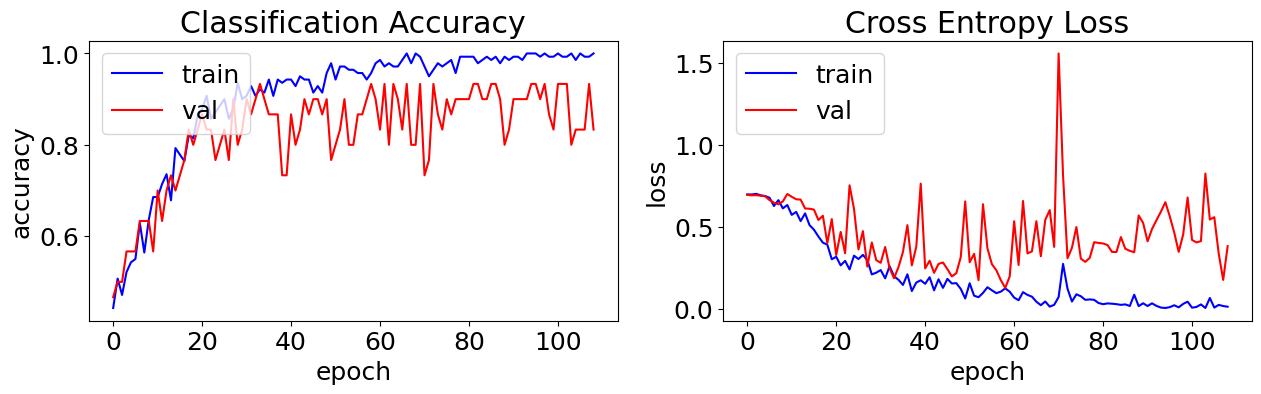

In [ ]:
trainModelNumpyAugment(baseline)

In [ ]:
my_path="Tiger-Fox-Elephant/"
my_classes=['tiger','Tiger_negative_class']
X, y = create_dataset(my_path, my_classes)
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.15, random_state=SEED) # .15 pour kfold et .3 pour normal

In [ ]:
trainModelNumpyKfoldAugment(baseline)

LSTM + Attention

In [ ]:
#trainModelNumpyKfoldAugment(get_2d_conv_LSTM_model)

In [ ]:
#trainModelNumpyKfoldAugment(get_2d_conv_LSTM_atten_model)

## Transfer learning

Testing pretrained model without use transfert learning

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
TestingAlreadyTrainedModel(VGG16) # Add/Change the model Name for changing the pretaining model

553467096/553467096 [==============================] - 7s 0us/step
model VGG16 as a resolution input img :  (224, 224)
35363/35363 [==============================] - 0s 0us/step
For the class tiger, the accuracy is 84.00%
The mean probability score for the correct predictions is 80.55455088615417 %
The most frequently confuse animal is fountain

For the class elephant, the accuracy is 95.00%
The mean probability score for the correct predictions is 53.52769494056702 %
The most frequently confuse animal is Arabian_camel

For the class fox, the accuracy is 28.00%
The mean probability score for the correct predictions is 40.16676843166351 %
The most frequently confuse animal is cliff



Transfer learning (check model here : https://keras.io/api/applications/)

Testing the first architecture

In [ ]:
my_path="Tiger-Fox-Elephant/"
my_classes=['tiger','Tiger_negative_class']
X, y = create_dataset(my_path, my_classes)
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.3, random_state=SEED) # .15 pour kfold et .3 pour normal
X_test, X_val, Y_test, Y_val = train_test_split(X_test, Y_test, test_size=0.5, random_state=SEED)
print(f"Taille de X_train : {len(X_train)}, Taille de X_val : {len(X_val)}, Taille de X_test : {len(X_test)}")

Les classes :  ['tiger', 'Tiger_negative_class']
Nombres de données :  200
Résolution des images :  (256, 256, 3)
Taille de X_train : 140, Taille de X_val : 30, Taille de X_test : 30


In [ ]:
trainModelNumpyAugment(TLModelArchi_1, VGG16) # Add/Change the model Name for changing the pretaining model

Testing the second architecture

Epoch 1/200
35/35 [==============================] - ETA: 0s - loss: 0.7460 - accuracy: 0.5852 - precision: 0.5741 - recall: 0.6966 - f1_score: 0.6294
Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to Saved_Model/TLModelArchi_2VGG16.h5
35/35 [==============================] - 6s 135ms/step - loss: 0.7460 - accuracy: 0.5852 - precision: 0.5741 - recall: 0.6966 - f1_score: 0.6294 - val_loss: 0.6897 - val_accuracy: 0.5000 - val_precision: 0.4118 - val_recall: 0.5833 - val_f1_score: 0.4828 - lr: 1.0000e-05
Epoch 2/200
35/35 [==============================] - ETA: 0s - loss: 0.6862 - accuracy: 0.5714 - precision: 0.5806 - recall: 0.5143 - f1_score: 0.5455
Epoch 2: val_accuracy improved from 0.50000 to 0.66667, saving model to Saved_Model/TLModelArchi_2VGG16.h5
35/35 [==============================] - 3s 82ms/step - loss: 0.6862 - accuracy: 0.5714 - precision: 0.5806 - recall: 0.5143 - f1_score: 0.5455 - val_loss: 0.6703 - val_accuracy: 0.6667 - val_precision: 0.5833 - val

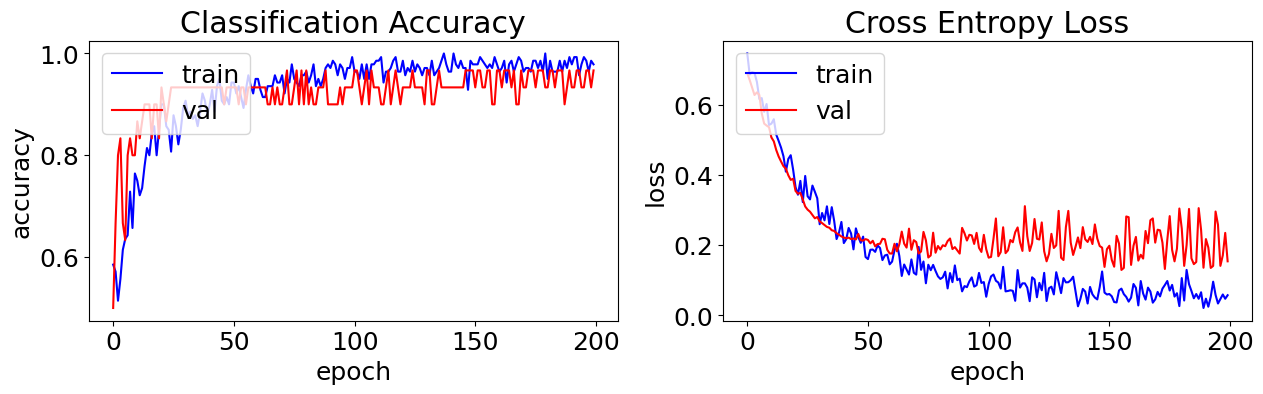

In [ ]:
trainModelNumpyAugment(TLModelArchi_2, VGG16) # Add/Change the model Name for changing the pretaining model

Testing with all model trainable parameter

In [ ]:
trainModelNumpyKfoldAugment(TLModelArchi_2Trainable, VGG16) # Add/Change the model Name for changing the pretaining model

VGG19

In [ ]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input, decode_predictions
TestingAlreadyTrainedModel(VGG19) # Add/Change the model Name for changing the pretaining model

In [ ]:
trainModelNumpyKfoldAugment(TLModelArchi_2, VGG19) # Add/Change the model Name for changing the pretaining model

ResNet50v2

In [ ]:
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.applications.resnet_v2 import preprocess_input, decode_predictions
TestingAlreadyTrainedModel(ResNet50V2) # Add/Change the model Name for changing the pretaining model

In [ ]:
trainModelNumpyKfoldAugment(TLModelArchi_2, ResNet50V2) # Add/Change the model Name for changing the pretaining model

EfficientNetV2L

In [ ]:
from tensorflow.keras.applications import EfficientNetV2L
trainModelNumpyKfoldAugment(TLModelArchi_2, EfficientNetV2L) # Add/Change the model Name for changing the pretaining model

InceptionV3

In [ ]:
from tensorflow.keras.applications import InceptionV3 # Scale input pixels between -1 and 1.
X = tf.keras.applications.mobilenet.preprocess_input(X)
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.15, random_state=SEED) # .15 pour kfold et .3 pour normal
trainModelNumpyKfoldAugment(TLModelArchi_2, InceptionV3) # Add/Change the model Name for changing the pretaining model

## Fine tuning

In [ ]:
my_path="Tiger-Fox-Elephant/"
my_classes=['tiger','Tiger_negative_class']
X, y = create_dataset(my_path, my_classes)
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.15, random_state=SEED) # .15 pour kfold et .3 pour normal

In [ ]:
model = VGG16(include_top=False)

n=1
for layer in model.layers :
  print(layer.name, n)
  n+=1

In [ ]:
fine_layer_tune=[17, 15, 11] # Définit selon les blocks du model
FineTuningKfoldingAugment(VGG16, fine_layer_tune)

In [ ]:
model = EfficientNetV2L(include_top=False)

n=1
for layer in model.layers :
  print(layer.name, n)
  n+=1

In [ ]:
fine_layer_tune=[981,951,923,848,728]
FineTuningKfoldingAugment(EfficientNetV2L, fine_layer_tune)

In [ ]:
model = ResNet50V2(include_top=False)

n=1
for layer in model.layers :
  print(layer.name, n)
  n+=1

In [ ]:
fine_layer_tune=[178,167,155,87]
FineTuningKfoldingAugment(ResNet50V2, fine_layer_tune)

## Stacking

In [ ]:
my_path="Tiger-Fox-Elephant/"
my_classes=['tiger','Tiger_negative_class']
X, y = create_dataset(my_path, my_classes)
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.3, random_state=SEED) # .15 pour kfold et .3 pour normal
X_test, X_val, Y_test, Y_val = train_test_split(X_test, Y_test, test_size=0.5, random_state=SEED)
print(f"Taille de X_train : {len(X_train)}, Taille de X_val : {len(X_val)}, Taille de X_test : {len(X_test)}")

In [ ]:
ListModel=["Saved_Model/TLModelArchi_2VGG16.h5","Saved_Model/TLModelArchi_2EfficientNetV2L.h5", "Saved_Model/TLModelArchi_2ResNet50V2.h5"]
histories3, score3 = trainModelNumpyAugment(stacked_model(ListModel))